<a href="https://colab.research.google.com/github/rcout328/Ai-saas/blob/main/scamsafe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import random
import datetime

def generate_date():
    return (datetime.datetime.now() - datetime.timedelta(days=random.randint(0, 30))).strftime("%b %d, %Y")

def generate_time():
    return f"{random.randint(1, 12):02d}:{random.randint(0, 59):02d} {'AM' if random.random() < 0.5 else 'PM'}"

def generate_tracking_number():
    return ''.join(random.choices('ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789', k=10))

def generate_order_number():
    return ''.join(random.choices('0123456789', k=8))

def generate_account_number():
    return ''.join(random.choices('0123456789', k=4))

scam_templates = [
    "URGENT: Your {bank} account ending in {account_number} has been locked. Click here to verify your identity and restore access immediately.",
    "Congratulations! You've won ${amount} in our lottery. To claim your prize, pay a processing fee of ${fee}. Reply 'YES' to proceed.",
    "Your {device} has a VIRUS! Call our Microsoft certified technicians now at 1-800-XXX-XXXX to remove it before your data is stolen.",
    "ALERT: Unauthorized login attempt detected on your {social_media} account. Click this link to secure your account now.",
    "You've been selected for a exclusive job opportunity! Earn ${amount}/week working from home. Small registration fee required. Apply now!",
    "Your {relative} is in trouble and needs ${amount} immediately. Please send money via Western Union to this account: {account_number}.",
    "FINAL NOTICE: Your {utility} bill is overdue. Pay ${amount} now to avoid service disconnection. Click here to make a payment.",
    "Your {delivery_service} package is held at customs. Pay ${amount} in fees to release it. Click here to complete the payment.",
    "Limited time offer: Get 90% off on all {product_category}! Click here to access our exclusive online store. Don't miss out!",
    "Your {bank} credit card has been charged ${amount} for a purchase you didn't make. Call this number immediately to dispute: 1-888-XXX-XXXX"
]

non_scam_templates = [
    "Your {online_store} order #{order_number} has shipped. Track your package here: {tracking_link}",
    "Reminder: Your appointment with Dr. {doctor_name} is tomorrow at {time}. Please arrive 15 minutes early.",
    "Your {bank} account statement for {month} is now available. Log in to your online banking to view.",
    "Thanks for your recent purchase at {store}! Here's a 10% off coupon for your next visit: {coupon_code}",
    "{airline} flight {flight_number} to {destination} is on time. Boarding starts at {time} at Gate {gate}.",
    "Your {subscription_service} subscription will renew on {date}. Update your preferences here: {settings_link}",
    "New message from {sender} on {dating_app}: 'Hi there! I liked your profile. Want to chat?'",
    "Your {food_delivery} order from {restaurant} is on its way. Estimated delivery time: {time}",
    "{gym_name} class reminder: Your {class_type} class starts at {time} tomorrow. Don't forget your water bottle!",
    "Software update available for your {device}. Tap here to install the latest security patches and improvements."
]

banks = ["Chase", "Bank of America", "Wells Fargo", "Citibank", "Capital One"]
devices = ["iPhone", "Android phone", "laptop", "tablet", "smart TV"]
social_media = ["Facebook", "Instagram", "Twitter", "LinkedIn", "TikTok"]
relatives = ["brother", "sister", "cousin", "uncle", "aunt"]
utilities = ["electricity", "water", "gas", "internet", "cable TV"]
delivery_services = ["UPS", "FedEx", "DHL", "USPS", "Amazon Logistics"]
product_categories = ["electronics", "designer clothes", "luxury watches", "skincare products", "supplements"]
online_stores = ["Amazon", "eBay", "Walmart", "Target", "Best Buy"]
airlines = ["Delta", "United", "American Airlines", "Southwest", "JetBlue"]
subscription_services = ["Netflix", "Spotify", "Amazon Prime", "Disney+", "Hulu"]
dating_apps = ["Tinder", "Bumble", "Hinge", "OkCupid", "Match.com"]
food_delivery = ["Uber Eats", "DoorDash", "Grubhub", "Postmates", "Deliveroo"]
gyms = ["LA Fitness", "Planet Fitness", "24 Hour Fitness", "Equinox", "Gold's Gym"]

def generate_scam_message():
    template = random.choice(scam_templates)
    return template.format(
        bank=random.choice(banks),
        account_number=generate_account_number(),
        amount=random.randint(100, 10000),
        fee=random.randint(50, 500),
        device=random.choice(devices),
        social_media=random.choice(social_media),
        relative=random.choice(relatives),
        utility=random.choice(utilities),
        delivery_service=random.choice(delivery_services),
        product_category=random.choice(product_categories)
    )

def generate_non_scam_message():
    template = random.choice(non_scam_templates)
    return template.format(
        online_store=random.choice(online_stores),
        order_number=generate_order_number(),
        tracking_link="https://track.example.com/" + generate_tracking_number(),
        doctor_name=f"Dr. {random.choice(['Smith', 'Johnson', 'Williams', 'Jones', 'Brown'])}",
        time=generate_time(),
        bank=random.choice(banks),
        month=random.choice(["January", "February", "March", "April", "May", "June"]),
        store=random.choice(["Target", "Walmart", "Macy's", "Kohl's", "Home Depot"]),
        coupon_code=''.join(random.choices('ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789', k=8)),
        airline=random.choice(airlines),
        flight_number=f"{random.choice(['AA', 'UA', 'DL', 'WN'])}{random.randint(100, 9999)}",
        destination=random.choice(["New York", "Los Angeles", "Chicago", "Miami", "San Francisco"]),
        gate=f"{random.choice('ABCDE')}{random.randint(1, 50)}",
        subscription_service=random.choice(subscription_services),
        date=generate_date(),
        settings_link="https://settings.example.com/" + ''.join(random.choices('abcdefghijklmnopqrstuvwxyz0123456789', k=10)),
        sender=random.choice(["Alex", "Sam", "Jordan", "Taylor", "Casey"]),
        dating_app=random.choice(dating_apps),
        food_delivery=random.choice(food_delivery),
        restaurant=random.choice(["Pizza Hut", "McDonald's", "Subway", "Chipotle", "Burger King"]),
        gym_name=random.choice(gyms),
        class_type=random.choice(["yoga", "spin", "HIIT", "pilates", "zumba"]),
        device=random.choice(devices)
    )

messages = []
for _ in range(300):
    if random.random() < 0.3:  # 30% chance of scam message
        messages.append(generate_scam_message())
    else:
        messages.append(generate_non_scam_message())

# Output messages in list format
print("messages = [")
for message in messages:
    print(f"    \"{message}\",")
print("]")

print(f"\nTotal messages generated: {len(messages)}")

messages = [
    "Your Spotify subscription will renew on Jun 14, 2024. Update your preferences here: https://settings.example.com/3s6o2mzdiq",
    "URGENT: Your Capital One account ending in 5010 has been locked. Click here to verify your identity and restore access immediately.",
    "Southwest flight UA9756 to Chicago is on time. Boarding starts at 10:53 AM at Gate E33.",
    "24 Hour Fitness class reminder: Your spin class starts at 01:43 AM tomorrow. Don't forget your water bottle!",
    "Reminder: Your appointment with Dr. Dr. Smith is tomorrow at 08:23 PM. Please arrive 15 minutes early.",
    "Congratulations! You've won $7396 in our lottery. To claim your prize, pay a processing fee of $193. Reply 'YES' to proceed.",
    "Thanks for your recent purchase at Home Depot! Here's a 10% off coupon for your next visit: CPPA48F5",
    "24 Hour Fitness class reminder: Your pilates class starts at 02:14 PM tomorrow. Don't forget your water bottle!",
    "FINAL NOTICE: Your internet bill

Epoch [1/10], Loss: 0.3285
Epoch [3/10], Loss: 0.1556
Epoch [5/10], Loss: 0.0210
Epoch [7/10], Loss: 0.0096
Epoch [9/10], Loss: 0.0213


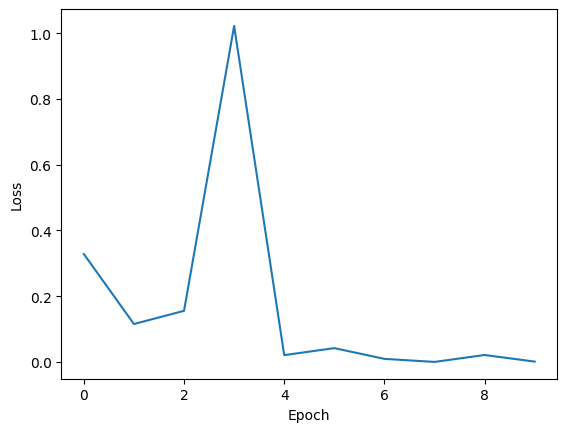

Accuracy: 0.8447
Message: Start earning $5000 a week from the comfort of your home. Sign up now!
Predicted result: scam

Message: Invest in this exclusive opportunity and double your money in a month!
Predicted result: scam

Message: Unlock the secret to making thousands of dollars online with minimal effort.
Predicted result: scam

Message: Join our investment group and see returns like never before!
Predicted result: ham

Message: Make a six-figure income working part-time. Learn how!
Predicted result: ham

Message: Discover the easiest way to get rich quick. Click here!
Predicted result: scam

Message: Turn your savings into a fortune with our investment plan.
Predicted result: scam

Message: Earn passive income effortlessly. Register today!
Predicted result: scam

Message: Be your own boss and make money fast. Start now!
Predicted result: scam

Message: Exclusive offer: triple your earnings in just weeks!
Predicted result: scam

Message: Congratulations! You've won a $1000 gift car

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('/content/drive/MyDrive/scam4.csv', encoding='latin-1')

# Preprocess text data
data['v2'].fillna('', inplace=True)

# Add system message to the input data
data['v2'] = data['v2'].apply(lambda x: f"System: This message needs to be classified as scam or ham. Message: {x}")

# Preprocess text data
X = data['v2']
y = data['v1'].apply(lambda x: 1 if x == 'scam' else 0)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text to numerical values
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_vectorized.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_vectorized.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define the neural network model
class SMSNet(nn.Module):
    def __init__(self, input_size=20, h1=128, h2=62, out_features=1):
        super(SMSNet, self).__init__()
        self.fc1 = nn.Linear(input_size, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.out(x))
        return x

input_size = X_train_vectorized.shape[1]
model = SMSNet(input_size)

# Set the criterion and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 10
losses = []
for epoch in range(epochs):
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses.append(loss.item())
    if epoch % 2 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Plot the training loss
plt.plot(range(epochs), losses)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

# Evaluate the model
with torch.no_grad():
    outputs = model(X_test_tensor).squeeze()
    predicted = (outputs > 0.5).float()
    accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.shape[0]
    print(f'Accuracy: {accuracy:.4f}')

def preprocess_message(message, vectorizer):
    system_message = f"System: This message needs to be classified as scam or ham. Message: {message}"
    message_vectorized = vectorizer.transform([system_message])
    message_tensor = torch.tensor(message_vectorized.toarray(), dtype=torch.float32)
    return message_tensor

def predict_message(model, message_tensor):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        output = model(message_tensor)
        prediction = (output > 0.5).float().item()
    return prediction

def interpret_prediction(prediction):
    return 'scam' if prediction == 1 else 'ham'

# Function to check multiple messages
def check_multiple_messages(model, messages, vectorizer):
    results = []
    for message in messages:
        message_tensor = preprocess_message(message, vectorizer)
        prediction = predict_message(model, message_tensor)
        result = interpret_prediction(prediction)
        results.append((message, result))
    return results

new_messages = [
    # Financial Opportunity Scams
    "Start earning $5000 a week from the comfort of your home. Sign up now!",
    "Invest in this exclusive opportunity and double your money in a month!",
    "Unlock the secret to making thousands of dollars online with minimal effort.",
    "Join our investment group and see returns like never before!",
    "Make a six-figure income working part-time. Learn how!",
    "Discover the easiest way to get rich quick. Click here!",
    "Turn your savings into a fortune with our investment plan.",
    "Earn passive income effortlessly. Register today!",
    "Be your own boss and make money fast. Start now!",
    "Exclusive offer: triple your earnings in just weeks!",

    # Prize Scams
    "Congratulations! You've won a $1000 gift card. Claim now!",
    "You are the lucky winner of a brand new car! Click to receive.",
    "Redeem your free vacation package today. Limited time offer!",
    "You've been selected for a free movie ticket. Claim now.",
    "Win a year's supply of groceries. Enter your details here.",
    "Claim your prize: a luxury cruise for two. Act fast!",
    "You have won a free laptop. Provide your info to get it.",
    "Your email has won a cash prize. Click to collect!",
    "Receive a free smartphone by participating in our survey.",
    "You've been chosen to win a $500 shopping spree. Claim today!",

    # Offer Scams
    "Win a free weekend getaway! Enter now.",
    "Get a free iPad by signing up for our newsletter.",
    "Receive a free gift card for completing this short survey.",
    "Exclusive offer: free gym membership for a year. Join now!",
    "Try our product for free. Click here to get your sample.",
    "Claim your free e-book on financial freedom. Download now!",
    "Get a free trial of our premium service. Limited spots available.",
    "Receive a free fashion makeover. Register today!",
    "Enter to win a free home makeover. Sign up now!",
    "Get a free month of streaming service. Subscribe here.",

    # Security Scams
    "Your recent payment was declined. Update your information.",
    "Suspicious activity detected on your account. Verify now.",
    "Your account has been locked. Click to unlock.",
    "We detected a security breach. Secure your account immediately.",
    "Your password is about to expire. Change it now.",
    "Unusual login attempt detected. Confirm your identity.",
    "Your account will be suspended. Verify your details.",
    "Urgent: update your payment information to avoid service disruption.",
    "Security alert: unauthorized access to your account. Act now!",
    "Your account needs verification. Click here to proceed.",

    # False Purchase/Shipment Scams
    "Your order has been shipped. Track it here.",
    "We couldn't deliver your package. Update your address.",
    "Your recent purchase was successful. View receipt.",
    "Your package is on hold. Confirm your delivery details.",
    "Your shipment is delayed. Check status here.",
    "Payment failed for your recent order. Retry payment.",
    "Your item is out of stock. Choose a replacement.",
    "Order confirmation needed. Verify purchase details.",
    "Your delivery is scheduled. View tracking information.",
    "Your purchase has been cancelled. Contact support.",
]

# Get predictions for multiple messages
results = check_multiple_messages(model, new_messages, vectorizer)

# Print the results
for message, result in results:
    print(f'Message: {message}\nPredicted result: {result}\n')

Epoch [1/100], Loss: 0.6932, Val Loss: 0.6930
Epoch [2/100], Loss: 0.6927, Val Loss: 0.6927
Epoch [3/100], Loss: 0.6919, Val Loss: 0.6922
Epoch [4/100], Loss: 0.6915, Val Loss: 0.6913
Epoch [5/100], Loss: 0.6897, Val Loss: 0.6898
Epoch [6/100], Loss: 0.6879, Val Loss: 0.6875
Epoch [7/100], Loss: 0.6837, Val Loss: 0.6840
Epoch [8/100], Loss: 0.6785, Val Loss: 0.6791
Epoch [9/100], Loss: 0.6727, Val Loss: 0.6724
Epoch [10/100], Loss: 0.6629, Val Loss: 0.6638
Epoch [11/100], Loss: 0.6522, Val Loss: 0.6524
Epoch [12/100], Loss: 0.6355, Val Loss: 0.6380
Epoch [13/100], Loss: 0.6160, Val Loss: 0.6194
Epoch [14/100], Loss: 0.5901, Val Loss: 0.5957
Epoch [15/100], Loss: 0.5539, Val Loss: 0.5672
Epoch [16/100], Loss: 0.5138, Val Loss: 0.5367
Epoch [17/100], Loss: 0.4686, Val Loss: 0.5062
Epoch [18/100], Loss: 0.4201, Val Loss: 0.4773
Epoch [19/100], Loss: 0.3828, Val Loss: 0.4534
Epoch [20/100], Loss: 0.3410, Val Loss: 0.4276
Epoch [21/100], Loss: 0.3000, Val Loss: 0.4055
Epoch [22/100], Loss: 

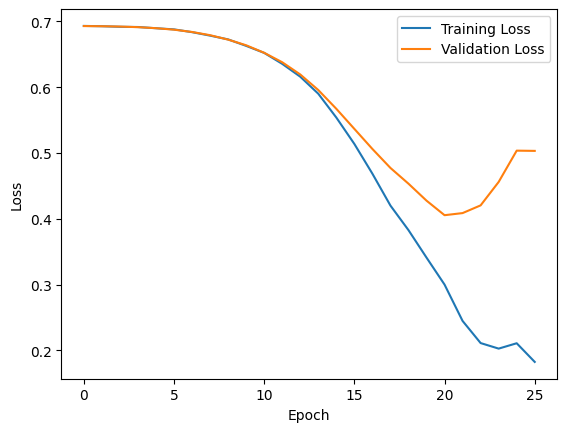

Accuracy: 0.8374
Message: Start earning $5000 a week from the comfort of your home. Sign up now!
Prediction: scam

Message: Invest in this exclusive opportunity and double your money in a month!
Prediction: scam

Message: Unlock the secret to making thousands of dollars online with minimal effort.
Prediction: ham

Message: Join our investment group and see returns like never before!
Prediction: ham

Message: Make a six-figure income working part-time. Learn how!
Prediction: ham

Message: Discover the easiest way to get rich quick. Click here!
Prediction: scam

Message: Turn your savings into a fortune with our investment plan.
Prediction: scam

Message: Earn passive income effortlessly. Register today!
Prediction: scam

Message: Be your own boss and make money fast. Start now!
Prediction: scam

Message: Exclusive offer: triple your earnings in just weeks!
Prediction: scam

Message: Congratulations! You've won a $1000 gift card. Claim now!
Prediction: scam

Message: You are the lucky wi

In [18]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('/content/drive/MyDrive/scam4.csv', encoding='latin-1')

# Preprocess text data
data['v2'].fillna('', inplace=True)

# Add system message to the input data
data['v2'] = data['v2'].apply(lambda x: f"System: This message needs to be classified as scam or ham. Message: {x}")

# Preprocess text data
X = data['v2']
y = data['v1'].apply(lambda x: 1 if x == 'scam' else 0)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text to numerical values
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_vectorized.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_vectorized.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=4000, shuffle=True)

# Define the neural network model
class SMSNet(nn.Module):
    def __init__(self, input_size=6000, h1=62, h2=62, h3=62, h4=62, h5=62, out_features=1):
        super(SMSNet, self).__init__()
        self.fc1 = nn.Linear(input_size, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.fc4 = nn.Linear(h3, h4)
        self.fc5 = nn.Linear(h4, h5)
        self.out = nn.Linear(h5, out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = torch.sigmoid(self.out(x))
        return x

input_size = X_train_vectorized.shape[1]
model = SMSNet(input_size)

# Set the criterion and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=1.1)

# Early stopping parameters
patience = 5
best_loss = float('inf')
patience_counter = 0

# Train the model
epochs = 100
losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    scheduler.step()  # Update the learning rate

    # Calculate validation loss
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor).squeeze()
        val_loss = criterion(val_outputs, y_test_tensor).item()
        val_losses.append(val_loss)

    losses.append(loss.item())
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

    # Check for early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# Plot the training and validation loss
plt.plot(range(len(losses)), losses, label='Training Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# Evaluate the model
with torch.no_grad():
    outputs = model(X_test_tensor).squeeze()
    predicted = (outputs > 0.5).float()
    accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.shape[0]
    print(f'Accuracy: {accuracy:.4f}')

def preprocess_message(message, vectorizer):
    system_message = f"System: This message needs to be classified as scam or ham. Message: {message}"
    message_vectorized = vectorizer.transform([system_message])
    message_tensor = torch.tensor(message_vectorized.toarray(), dtype=torch.float32)
    return message_tensor

def predict_message(model, message_tensor):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        output = model(message_tensor)
        prediction = (output > 0.5).float().item()
    return prediction

def interpret_prediction(prediction):
    return 'scam' if prediction == 1 else 'ham'

# Function to check multiple messages
def check_multiple_messages(model, messages, vectorizer):
    results = []
    for message in messages:
        message_tensor = preprocess_message(message, vectorizer)
        prediction = predict_message(model, message_tensor)
        result = interpret_prediction(prediction)
        results.append((message, result))
    return results

new_messages = [
    # Financial Opportunity Scams
    "Start earning $5000 a week from the comfort of your home. Sign up now!",
    "Invest in this exclusive opportunity and double your money in a month!",
    "Unlock the secret to making thousands of dollars online with minimal effort.",
    "Join our investment group and see returns like never before!",
    "Make a six-figure income working part-time. Learn how!",
    "Discover the easiest way to get rich quick. Click here!",
    "Turn your savings into a fortune with our investment plan.",
    "Earn passive income effortlessly. Register today!",
    "Be your own boss and make money fast. Start now!",
    "Exclusive offer: triple your earnings in just weeks!",

    # Prize Scams
    "Congratulations! You've won a $1000 gift card. Claim now!",
    "You are the lucky winner of a brand new car! Click to receive.",
    "Redeem your free vacation package today. Limited time offer!",
    "You've been selected for a free movie ticket. Claim now.",
    "Win a year's supply of groceries. Enter your details here.",
    "Claim your prize: a luxury cruise for two. Act fast!",
    "You have won a free laptop. Provide your info to get it.",
    "Your email has won a cash prize. Click to collect!",
    "Receive a free smartphone by participating in our survey.",
    "You've been chosen to win a $500 shopping spree. Claim today!",

    # Offer Scams
    "Win a free weekend getaway! Enter now.",
    "Get a free iPad by signing up for our newsletter.",
    "Receive a free gift card for completing this short survey.",
    "Exclusive offer: free gym membership for a year. Join now!",
    "Try our product for free. Click here to get your sample.",
    "Claim your free e-book on financial freedom. Download now!",
    "Get a free trial of our premium service. Limited spots available.",
    "Receive a free fashion makeover. Register today!",
    "Enter to win a free home makeover. Sign up now!",
    "Get a free month of streaming service. Subscribe here.",

    # Security Scams
    "Your recent payment was declined. Update your information.",
    "Suspicious activity detected on your account. Verify now.",
    "Your account has been locked. Click to unlock.",
    "We detected a security breach. Secure your account immediately.",
    "Your password is about to expire. Change it now.",
    "Unusual login attempt detected. Confirm your identity.",
    "Your account will be suspended. Verify your details.",
    "Urgent: update your payment information to avoid service disruption.",
    "Security alert: unauthorized access to your account. Act now!",
    "Your account needs verification. Click here to proceed.",

    # False Purchase/Shipment Scams
    "Your order has been shipped. Track it here.",
    "We couldn't deliver your package. Update your address.",
    "Your recent purchase was successful. View receipt.",
    "Your package is on hold. Confirm your delivery details.",
    "Your shipment is delayed. Check status here.",
    "Payment failed for your recent order. Retry payment.",
    "Your item is out of stock. Choose a replacement.",
    "Order confirmation needed. Verify purchase details.",
    "Your delivery is scheduled. View tracking information.",
    "Your purchase has been cancelled. Contact support."
]

results = check_multiple_messages(model, new_messages, vectorizer)
for message, result in results:
    print(f'Message: {message}\nPrediction: {result}\n')


Epoch [1/100], Loss: 0.5812, Val Loss: 0.5753
Epoch [2/100], Loss: 0.4383, Val Loss: 0.4209
Epoch [3/100], Loss: 0.3314, Val Loss: 0.3472
Epoch [4/100], Loss: 0.2530, Val Loss: 0.3407
Epoch [5/100], Loss: 0.2244, Val Loss: 0.3426
Epoch [6/100], Loss: 0.2135, Val Loss: 0.3538
Epoch [7/100], Loss: 0.1009, Val Loss: 0.3448
Epoch [8/100], Loss: 0.0809, Val Loss: 0.4015
Epoch [9/100], Loss: 0.1181, Val Loss: 0.4186
Early stopping triggered


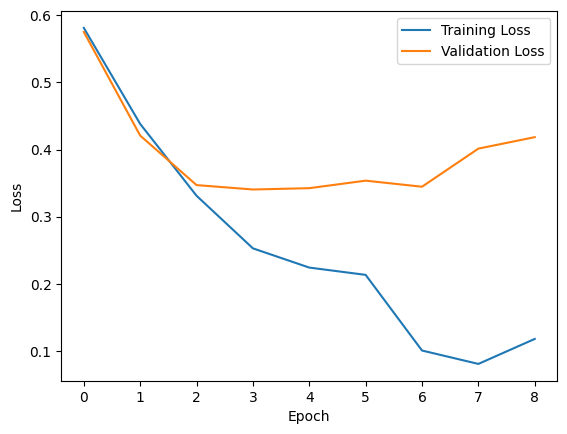

Accuracy: 0.8544
Message: Start earning $5000 a week from the comfort of your home. Sign up now!
Prediction: ham

Message: Invest in this exclusive opportunity and double your money in a month!
Prediction: scam

Message: Unlock the secret to making thousands of dollars online with minimal effort.
Prediction: ham

Message: Join our investment group and see returns like never before!
Prediction: ham

Message: Make a six-figure income working part-time. Learn how!
Prediction: ham

Message: Discover the easiest way to get rich quick. Click here!
Prediction: ham

Message: Turn your savings into a fortune with our investment plan.
Prediction: ham

Message: Earn passive income effortlessly. Register today!
Prediction: scam

Message: Be your own boss and make money fast. Start now!
Prediction: scam

Message: Exclusive offer: triple your earnings in just weeks!
Prediction: scam

Message: Congratulations! You've won a $1000 gift card. Claim now!
Prediction: scam

Message: You are the lucky winne

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('/content/drive/MyDrive/scam4.csv', encoding='latin-1')

# Preprocess text data
data['v2'].fillna('', inplace=True)

# Add system message to the input data
data['v2'] = data['v2'].apply(lambda x: f"System: This message needs to be classified as scam or ham. Message: {x}")

# Preprocess text data
X = data['v2']
y = data['v1'].apply(lambda x: 1 if x == 'scam' else 0)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text to numerical values
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_vectorized.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_vectorized.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define the neural network model
class SMSNet(nn.Module):
    def __init__(self, input_size):
        super(SMSNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(64, 32)
        self.bn5 = nn.BatchNorm1d(32)
        self.out = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.dropout(x)
        x = F.relu(self.bn5(self.fc5(x)))
        x = self.dropout(x)
        x = torch.sigmoid(self.out(x))
        return x

input_size = X_train_vectorized.shape[1]
model = SMSNet(input_size)

# Set the criterion and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Early stopping parameters
patience = 5
best_loss = float('inf')
patience_counter = 0

# Train the model
epochs = 100
losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    scheduler.step()  # Update the learning rate

    # Calculate validation loss
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor).squeeze()
        val_loss = criterion(val_outputs, y_test_tensor).item()
        val_losses.append(val_loss)

    losses.append(loss.item())
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

    # Check for early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# Plot the training and validation loss
plt.plot(range(len(losses)), losses, label='Training Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# Evaluate the model
with torch.no_grad():
    outputs = model(X_test_tensor).squeeze()
    predicted = (outputs > 0.5).float()
    accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.shape[0]
    print(f'Accuracy: {accuracy:.4f}')

def preprocess_message(message, vectorizer):
    system_message = f"System: This message needs to be classified as scam or ham. Message: {message}"
    message_vectorized = vectorizer.transform([system_message])
    message_tensor = torch.tensor(message_vectorized.toarray(), dtype=torch.float32)
    return message_tensor

def predict_message(model, message_tensor):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        output = model(message_tensor)
        prediction = (output > 0.5).float().item()
    return prediction

def interpret_prediction(prediction):
    return 'scam' if prediction == 1 else 'ham'

# Function to check multiple messages
def check_multiple_messages(model, messages, vectorizer):
    results = []
    for message in messages:
        message_tensor = preprocess_message(message, vectorizer)
        prediction = predict_message(model, message_tensor)
        result = interpret_prediction(prediction)
        results.append((message, result))
    return results
    new_messages = [
    # Financial Opportunity Scams
    "Start earning $5000 a week from the comfort of your home. Sign up now!",
    "Invest in this exclusive opportunity and double your money in a month!",
    "Unlock the secret to making thousands of dollars online with minimal effort.",
    "Join our investment group and see returns like never before!",
    "Make a six-figure income working part-time. Learn how!",
    "Discover the easiest way to get rich quick. Click here!",
    "Turn your savings into a fortune with our investment plan.",
    "Earn passive income effortlessly. Register today!",
    "Be your own boss and make money fast. Start now!",
    "Exclusive offer: triple your earnings in just weeks!",

    # Prize Scams
    "Congratulations! You've won a $1000 gift card. Claim now!",
    "You are the lucky winner of a brand new car! Click to receive.",
    "Redeem your free vacation package today. Limited time offer!",
    "You've been selected for a free movie ticket. Claim now.",

    # Security Scams
    "Your recent payment was declined. Update your information.",
    "Suspicious activity detected on your account. Verify now.",
    "Your account has been locked. Click to unlock.",
    "We detected a security breach. Secure your account immediately.",
    "Your password is about to expire. Change it now.",
    "Unusual login attempt detected. Confirm your identity.",
    "Your account will be suspended. Verify your details.",
    "Urgent: update your payment information to avoid service disruption.",
    "Security alert: unauthorized access to your account. Act now!",
    "Your account needs verification. Click here to proceed.",

    # Fal
]

results = check_multiple_messages(model, new_messages, vectorizer)
for message, result in results:
    print(f'Message: {message}\nPrediction: {result}\n')

Epoch [1/100], Loss: 0.5065, Val Loss: 0.4694
Epoch [2/100], Loss: 0.3725, Val Loss: 0.3602
Epoch [3/100], Loss: 0.2844, Val Loss: 0.3584
Epoch [4/100], Loss: 0.1687, Val Loss: 0.3718
Epoch [5/100], Loss: 0.0833, Val Loss: 0.3990
Epoch [6/100], Loss: 0.0722, Val Loss: 0.4041
Epoch [7/100], Loss: 0.2062, Val Loss: 0.4237
Epoch [8/100], Loss: 0.2027, Val Loss: 0.4695
Early stopping triggered


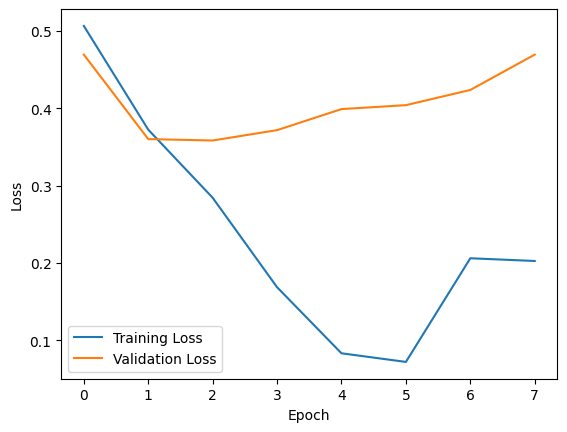

Accuracy: 0.8404
Message: Start earning $5000 a week from the comfort of your home. Sign up now!
Prediction: scam

Message: Invest in this exclusive opportunity and double your money in a month!
Prediction: scam

Message: Unlock the secret to making thousands of dollars online with minimal effort.
Prediction: scam

Message: Join our investment group and see returns like never before!
Prediction: ham

Message: Make a six-figure income working part-time. Learn how!
Prediction: ham

Message: Discover the easiest way to get rich quick. Click here!
Prediction: ham

Message: Turn your savings into a fortune with our investment plan.
Prediction: scam

Message: Earn passive income effortlessly. Register today!
Prediction: scam

Message: Be your own boss and make money fast. Start now!
Prediction: scam

Message: Exclusive offer: triple your earnings in just weeks!
Prediction: scam

Message: Congratulations! You've won a $1000 gift card. Claim now!
Prediction: scam

Message: You are the lucky wi

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# Load dataset
data = pd.read_csv('/content/drive/MyDrive/scam4.csv', encoding='latin-1')

# Preprocess text data
data['v2'].fillna('', inplace=True)

# Add system message to the input data
data['v2'] = data['v2'].apply(lambda x: f"System: This message needs to be classified as scam or ham. Message: {x}")

# Preprocess text data
X = data['v2']
y = data['v1'].apply(lambda x: 1 if x == 'scam' else 0)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text to numerical values using TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_vectorized.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_vectorized.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define the neural network model with LSTM
class SMSNet(nn.Module):
    def __init__(self, input_size):
        super(SMSNet, self).__init__()
        self.lstm = nn.LSTM(input_size, 128, batch_first=True)
        self.fc1 = nn.Linear(128, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.out = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add a dimension for LSTM
        _, (hn, _) = self.lstm(x)
        x = hn.squeeze(0)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = torch.sigmoid(self.out(x))
        return x

input_size = X_train_vectorized.shape[1]
model = SMSNet(input_size)

# Set the criterion and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Early stopping parameters
patience = 5
best_loss = float('inf')
patience_counter = 0

# Train the model
epochs = 100
losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    scheduler.step()  # Update the learning rate

    # Calculate validation loss
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor).squeeze()
        val_loss = criterion(val_outputs, y_test_tensor).item()
        val_losses.append(val_loss)

    losses.append(loss.item())
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

    # Check for early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# Plot the training and validation loss
plt.plot(range(len(losses)), losses, label='Training Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# Evaluate the model
with torch.no_grad():
    outputs = model(X_test_tensor).squeeze()
    predicted = (outputs > 0.5).float()
    accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.shape[0]
    print(f'Accuracy: {accuracy:.4f}')

def preprocess_message(message, vectorizer):
    system_message = f"System: This message needs to be classified as scam or ham. Message: {message}"
    message_vectorized = vectorizer.transform([system_message])
    message_tensor = torch.tensor(message_vectorized.toarray(), dtype=torch.float32)
    return message_tensor

def predict_message(model, message_tensor):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        output = model(message_tensor)
        prediction = (output > 0.5).float().item()
    return prediction

def interpret_prediction(prediction):
    return 'scam' if prediction == 1 else 'ham'

# Function to check multiple messages
def check_multiple_messages(model, messages, vectorizer):
    results = []
    for message in messages:
        message_tensor = preprocess_message(message, vectorizer)
        prediction = predict_message(model, message_tensor)
        result = interpret_prediction(prediction)
        results.append((message, result))
    return results


    new_messages = [
    # Financial Opportunity Scams
    "Start earning $5000 a week from the comfort of your home. Sign up now!",
    "Invest in this exclusive opportunity and double your money in a month!",
    "Unlock the secret to making thousands of dollars online with minimal effort.",
    "Join our investment group and see returns like never before!",
    "Make a six-figure income working part-time. Learn how!",
    "Discover the easiest way to get rich quick. Click here!",
    "Turn your savings into a fortune with our investment plan.",
    "Earn passive income effortlessly. Register today!",
    "Be your own boss and make money fast. Start now!",
    "Exclusive offer: triple your earnings in just weeks!",

    # Prize Scams
    "Congratulations! You've won a $1000 gift card. Claim now!",
    "You are the lucky winner of a brand new car! Click to receive.",
    "Redeem your free vacation package today. Limited time offer!",
    "You've been selected for a free movie ticket. Claim now.",
    "Win a year's supply of groceries. Enter your details here.",
    "Claim your prize: a luxury cruise for two. Act fast!",
    "You have won a free laptop. Provide your info to get it.",
    "Your email has won a cash prize. Click to collect!",
    "Receive a free smartphone by participating in our survey.",
    "You've been chosen to win a $500 shopping spree. Claim today!",

    # Offer Scams
    "Win a free weekend getaway! Enter now.",
    "Get a free iPad by signing up for our newsletter.",
    "Receive a free gift card for completing this short survey.",
    "Exclusive offer: free gym membership for a year. Join now!",
    "Try our product for free. Click here to get your sample.",
    "Claim your free e-book on financial freedom. Download now!",
    "Get a free trial of our premium service. Limited spots available.",
    "Receive a free fashion makeover. Register today!",
    "Enter to win a free home makeover. Sign up now!",
    "Get a free month of streaming service. Subscribe here.",

    # Security Scams
    "Your recent payment was declined. Update your information.",
    "Suspicious activity detected on your account. Verify now.",
    "Your account has been locked. Click to unlock.",
    "We detected a security breach. Secure your account immediately.",
    "Your password is about to expire. Change it now.",
    "Unusual login attempt detected. Confirm your identity.",
    "Your account will be suspended. Verify your details.",
    "Urgent: update your payment information to avoid service disruption.",
    "Security alert: unauthorized access to your account. Act now!",
    "Your account needs verification. Click here to proceed.",

    # False Purchase/Shipment Scams
    "Your order has been shipped. Track it here.",
    "We couldn't deliver your package. Update your address.",
    "Your recent purchase was successful. View receipt.",
    "Your package is on hold. Confirm your delivery details.",
    "Your shipment is delayed. Check status here.",
    "Payment failed for your recent order. Retry payment.",
    "Your item is out of stock. Choose a replacement.",
    "Order confirmation needed. Verify purchase details.",
    "Your delivery is scheduled. View tracking information.",
    "Your purchase has been cancelled. Contact support."
]

results = check_multiple_messages(model, new_messages, vectorizer)
for message, result in results:
    print(f'Message: {message}\nPrediction: {result}\n')

Epoch [1/50], Loss: 0.4228, Val Loss: 0.4479
Epoch [2/50], Loss: 0.2741, Val Loss: 0.3672
Epoch [3/50], Loss: 0.2971, Val Loss: 0.3696
Epoch [4/50], Loss: 0.2282, Val Loss: 0.3475
Epoch [5/50], Loss: 0.1495, Val Loss: 0.4511
Epoch [6/50], Loss: 0.1694, Val Loss: 0.4339
Epoch [7/50], Loss: 0.2403, Val Loss: 0.5404
Epoch [8/50], Loss: 0.1205, Val Loss: 0.5753
Epoch [9/50], Loss: 0.2291, Val Loss: 0.5759
Early stopping triggered


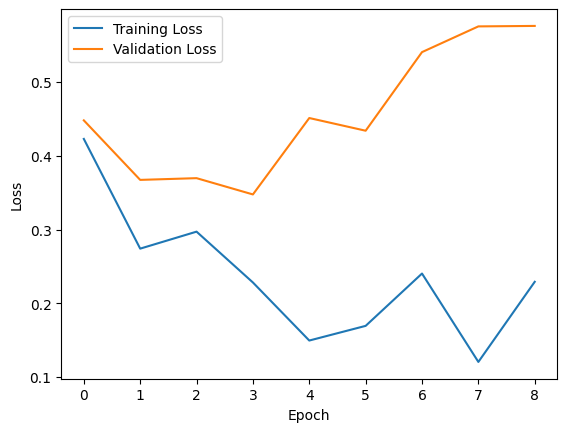

Accuracy: 0.8538
Message: Start earning $5000 a week from the comfort of your home. Sign up now!
Predicted result: scam

Message: Invest in this exclusive opportunity and double your money in a month!
Predicted result: scam

Message: Unlock the secret to making thousands of dollars online with minimal effort.
Predicted result: scam

Message: Join our investment group and see returns like never before!
Predicted result: ham

Message: Make a six-figure income working part-time. Learn how!
Predicted result: ham

Message: Discover the easiest way to get rich quick. Click here!
Predicted result: scam

Message: Turn your savings into a fortune with our investment plan.
Predicted result: scam

Message: Earn passive income effortlessly. Register today!
Predicted result: scam

Message: Be your own boss and make money fast. Start now!
Predicted result: scam

Message: Exclusive offer: triple your earnings in just weeks!
Predicted result: scam

Message: Congratulations! You've won a $1000 gift car

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('/content/drive/MyDrive/scam4.csv', encoding='latin-1')

# Preprocess text data
data['v2'].fillna('', inplace=True)

# Add system message to the input data
data['v2'] = data['v2'].apply(lambda x: f"System: This message needs to be classified as scam or ham. Message: {x}")

# Preprocess text data
X = data['v2']
y = data['v1'].apply(lambda x: 1 if x == 'scam' else 0)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text to numerical values
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_vectorized.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_vectorized.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Increased batch size

# Define the neural network model
class SMSNet(nn.Module):
    def __init__(self, input_size):
        super(SMSNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.out = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.out(x))
        return x

input_size = X_train_vectorized.shape[1]
model = SMSNet(input_size)

# Set the criterion and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Increased learning rate

# Early stopping parameters
patience = 5
best_loss = float('inf')
patience_counter = 0

# Train the model
epochs = 50  # Increased epochs
losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate validation loss
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor).squeeze()
        val_loss = criterion(val_outputs, y_test_tensor).item()
        val_losses.append(val_loss)

    losses.append(loss.item())
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

    # Check for early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# Plot the training and validation loss
plt.plot(range(len(losses)), losses, label='Training Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# Evaluate the model
with torch.no_grad():
    outputs = model(X_test_tensor).squeeze()
    predicted = (outputs > 0.5).float()
    accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.shape[0]
    print(f'Accuracy: {accuracy:.4f}')

def preprocess_message(message, vectorizer):
    system_message = f"System: This message needs to be classified as scam or ham. Message: {message}"
    message_vectorized = vectorizer.transform([system_message])
    message_tensor = torch.tensor(message_vectorized.toarray(), dtype=torch.float32)
    return message_tensor

def predict_message(model, message_tensor):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        output = model(message_tensor)
        prediction = (output > 0.5).float().item()
    return prediction

def interpret_prediction(prediction):
    return 'scam' if prediction == 1 else 'ham'

# Function to check multiple messages
def check_multiple_messages(model, messages, vectorizer):
    results = []
    for message in messages:
        message_tensor = preprocess_message(message, vectorizer)
        prediction = predict_message(model, message_tensor)
        result = interpret_prediction(prediction)
        results.append((message, result))
    return results

new_messages = [
    # Financial Opportunity Scams
    "Start earning $5000 a week from the comfort of your home. Sign up now!",
    "Invest in this exclusive opportunity and double your money in a month!",
    "Unlock the secret to making thousands of dollars online with minimal effort.",
    "Join our investment group and see returns like never before!",
    "Make a six-figure income working part-time. Learn how!",
    "Discover the easiest way to get rich quick. Click here!",
    "Turn your savings into a fortune with our investment plan.",
    "Earn passive income effortlessly. Register today!",
    "Be your own boss and make money fast. Start now!",
    "Exclusive offer: triple your earnings in just weeks!",

    # Prize Scams
    "Congratulations! You've won a $1000 gift card. Claim now!",
    "You are the lucky winner of a brand new car! Click to receive.",
    "Redeem your free vacation package today. Limited time offer!",
    "You've been selected for a free movie ticket. Claim now.",
    "Win a year's supply of groceries. Enter your details here.",
    "Claim your prize: a luxury cruise for two. Act fast!",
    "You have won a free laptop. Provide your info to get it.",
    "Your email has won a cash prize. Click to collect!",
    "Receive a free smartphone by participating in our survey.",
    "You've been chosen to win a $500 shopping spree. Claim today!",

    # Offer Scams
    "Win a free weekend getaway! Enter now.",
    "Get a free iPad by signing up for our newsletter.",
    "Receive a free gift card for completing this short survey.",
    "Exclusive offer: free gym membership for a year. Join now!",
    "Try our product for free. Click here to get your sample.",
    "Claim your free e-book on financial freedom. Download now!",
    "Get a free trial of our premium service. Limited spots available.",
    "Receive a free fashion makeover. Register today!",
    "Enter to win a free home makeover. Sign up now!",
    "Get a free month of streaming service. Subscribe here.",

    # Security Scams
    "Your recent payment was declined. Update your information.",
    "Suspicious activity detected on your account. Verify now.",
    "Your account has been locked. Click to unlock.",
    "We detected a security breach. Secure your account immediately.",
    "Your password is about to expire. Change it now.",
    "Unusual login attempt detected. Confirm your identity.",
    "Your account will be suspended. Verify your details.",
    "Urgent: update your payment information to avoid service disruption.",
    "Security alert: unauthorized access to your account. Act now!",
    "Your account needs verification. Click here to proceed.",

    # False Purchase/Shipment Scams
    "Your order has been shipped. Track it here.",
    "We couldn't deliver your package. Update your address.",
    "Your recent purchase was successful. View receipt.",
    "Your package is on hold. Confirm your delivery details.",
    "Your shipment is delayed. Check status here.",
    "Payment failed for your recent order. Retry payment.",
    "Your item is out of stock. Choose a replacement.",
    "Order confirmation needed. Verify purchase details.",
    "Your delivery is scheduled. View tracking information.",
    "Your purchase has been cancelled. Contact support.",
]

# Get predictions for multiple messages
results = check_multiple_messages(model, new_messages, vectorizer)

# Print the results
for message, result in results:
    print(f'Message: {message}\nPredicted result: {result}\n')


In [6]:
torch.save(model.state_dict(), 'scam.pth')

In [7]:
model = SMSNet()

In [8]:
model.load_state_dict(torch.load('scam.pth'))
model.eval()

RuntimeError: Error(s) in loading state_dict for SMSNet:
	size mismatch for fc1.weight: copying a param with shape torch.Size([128, 3808]) from checkpoint, the shape in current model is torch.Size([128, 20]).

In [21]:
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from typing import List
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.feature_extraction.text import CountVectorizer
import pickle

# Define your neural network model class
class SMSNet(nn.Module):
    def __init__(self, input_size=6000, h1=62, h2=62, h3=62 ,h4=62 ,h5=62 out_features=1):
        super(SMSNet, self).__init__()
        self.fc1 = nn.Linear(input_size, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.out(x))
        return x

# Define the message input model
class MessageInput(BaseModel):
    messages: List[str]

# Initialize FastAPI
app = FastAPI()

# Load your trained model
model_path = 'scam.pth'  # Update with your model path
new_model = SMSNet(input_size=6000)
new_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
new_model.eval()

# Load vectorizer
vectorizer = pickle.load(open("vectorizer.pkl", "rb"))

# Function to preprocess a single message
def preprocess_message(message, vectorizer):
    system_message = f"System: This message needs to be classified as scam or ham. Message: {message}"
    message_vectorized = vectorizer.transform([system_message])
    message_tensor = torch.tensor(message_vectorized.toarray(), dtype=torch.float32)
    return message_tensor

@app.post("/predict")
async def predict(input: MessageInput):
    messages = input.messages
    results = []

    for message in messages:
        message_tensor = preprocess_message(message, vectorizer)
        prediction = new_model(message_tensor)
        result = 'scam' if prediction.item() > 0.5 else 'ham'
        results.append(result)

    return {"results": results}

# For testing connection
@app.get("/")
async def read_root():
    return {"message": "API is working"}

if __name__ == '__main__':
    import uvicorn
    uvicorn.run(app, host="0.0.0.0", port=8000)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (<ipython-input-21-c3c79b8f7883>, line 12)

In [ ]:
import requests

url = 'http://localhost:5000/predict'
data = {'your': 'input data'}  # Replace with your actual input data
response = requests.post(url, json=data)
print(response.json())


In [ ]:
!pip install flask-ngrok

from flask import Flask, request, jsonify
from flask_ngrok import run_with_ngrok

app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok when app is run

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json  # Assuming the input data is sent as JSON
    input_tensor = preprocess(data)  # Preprocess the input data to the required format
    with torch.no_grad():
        output = model(input_tensor)
    prediction = postprocess(output)  # Convert the model output to a human-readable format
    return jsonify(prediction)

def preprocess(data):
    # Add your preprocessing logic here
    # Convert the input data to a tensor, etc.
    return input_tensor

def postprocess(output):
    # Add your postprocessing logic here
    # Convert the model output to a JSON-serializable format
    return prediction

if __name__ == '__main__':
    app.run()


In [ ]:
!pip install --quiet --upgrade google-cloud-storage
!pip install --quiet --upgrade google-cloud-sdk
from google.colab import auth
auth.authenticate_user()
!gcloud services enable run.googleapis.com
!gcloud services enable containerregistry.googleapis.com
!gcloud services enable cloudbuild.googleapis.com
